# SigLIP Ablation Notebook (Standalone + Verbose)
This notebook is **standalone**: a **2×2 ablation**:

- **Pretrained baseline (no training)**  
- **Baseline (trained, no MAN, no HNM)**  
- **MAN only** (MAN + standard contrastive loss)  
- **HNM only** (HNM + no MAN)  
- **MAN + HNM** (both)

After each run it computes retrieval metrics:
- Recall@1/5/10 for **Image→Text** and **Text→Image**
- Mean/Median rank

It also produces plots and qualitative retrieval examples.

 **Verbose**: long steps print progress (dataset saving, epochs, evaluation, qualitative).


In [ ]:
# ===== Install (Colab) =====
!pip -q install -U transformers datasets accelerate
!pip -q install "pillow<12"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 16.3 MB/s eta 0:00:00


In [ ]:
# ===== Imports =====
import os, json, random, math, time
from dataclasses import dataclass, asdict
from typing import Dict, Tuple, Optional

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import SiglipModel, SiglipProcessor
from accelerate import Accelerator
from tqdm.auto import tqdm
from transformers import SiglipProcessor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os, json, time, random
import numpy as np
import torch
from PIL import Image
from datasets import load_dataset

import matplotlib.pyplot as plt
import os, json
from PIL import Image
import os
import torch
from dataclasses import dataclass, asdict
from typing import Dict
import os
import torch
import torch.nn.functional as F
from accelerate import Accelerator



In [ ]:

# ===== Global config =====
SEED = 42

MODEL_NAME = "google/siglip-base-patch16-224"

# Dataset build size (start smaller for a quick dry-run if needed)
TRAIN_N = 25000
VAL_N   = 1000

# Training hyperparams
BATCH_SIZE  = 32
MAX_LEN     = 64
NUM_WORKERS = 0

EPOCHS_DEFAULT = 2
LR_DEFAULT = 3e-6
WEIGHT_DECAY_DEFAULT = 0.01
GRAD_CLIP_DEFAULT = 1.0

# Partial unfreezing
UNFREEZE_LAST_VISION_DEFAULT = 2
UNFREEZE_LAST_TEXT_DEFAULT   = 2

# HNM
HNM_K_DEFAULT = 10

# Paths (Colab/local runtime)
BASE_DIR  = "/content/dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")

RUNS_DIR    = "/content/ablation_runs"
RESULTS_DIR = "/content/ablation_results"

for p in [TRAIN_DIR, VAL_DIR, RUNS_DIR, RESULTS_DIR]:
    os.makedirs(p, exist_ok=True)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
print("CUDA:", torch.cuda.is_available())
print("TRAIN_DIR:", TRAIN_DIR)
print("VAL_DIR:", VAL_DIR)


CUDA: True
TRAIN_DIR: /content/dataset/train
VAL_DIR: /content/dataset/val


## 0) Build local dataset (from `jxie/coco_captions`)
Creates:
```
/content/dataset/train/images/*.jpg
/content/dataset/train/captions.jsonl
/content/dataset/val/images/*.jpg
/content/dataset/val/captions.jsonl
```
If these already exist with enough rows, it will **skip** rebuilding.


In [ ]:


def _count_jsonl(path: str):
    if not os.path.exists(path):
        return 0
    n = 0
    with open(path, "r", encoding="utf-8") as f:
        for _ in f:
            n += 1
    return n

def build_local_dataset_from_coco_captions(train_n: int, val_n: int, seed: int = 42, verbose_every: int = 500):
    # ensure split dirs exist
    os.makedirs(TRAIN_DIR, exist_ok=True)
    os.makedirs(VAL_DIR, exist_ok=True)

    train_ann = os.path.join(TRAIN_DIR, "captions.jsonl")
    val_ann   = os.path.join(VAL_DIR, "captions.jsonl")

    n_train = _count_jsonl(train_ann)
    n_val   = _count_jsonl(val_ann)

    if n_train >= train_n and n_val >= val_n:
        print(f" Dataset already exists. train={n_train}, val={n_val} (requested train={train_n}, val={val_n})")
        return

    print("Building dataset from jxie/coco_captions (streaming)...")
    os.makedirs(os.path.join(TRAIN_DIR, "images"), exist_ok=True)
    os.makedirs(os.path.join(VAL_DIR, "images"), exist_ok=True)

    def save_split_stream(stream, out_dir, n_samples, offset=0, seed_local=42):
        random.seed(seed_local)
        img_dir  = os.path.join(out_dir, "images")
        ann_path = os.path.join(out_dir, "captions.jsonl")

        if offset > 0:
            print(f" Skipping first {offset} samples in stream...")
            stream = stream.skip(offset)

        it = iter(stream)
        written = 0
        t0 = time.time()

        with open(ann_path, "w", encoding="utf-8") as f:
            while written < n_samples:
                ex = next(it)

                img = ex.get("image", None)
                cap = ex.get("caption", None)

                if img is None or not isinstance(cap, str) or not cap.strip():
                    continue

                img = img.convert("RGB")
                img_name = f"{written:06d}.jpg"
                img.save(os.path.join(img_dir, img_name), quality=95)

                f.write(json.dumps({"image": img_name, "text": cap.strip()}, ensure_ascii=False) + "\n")
                written += 1

                if written % verbose_every == 0:
                    dt = time.time() - t0
                    rate = written / max(dt, 1e-6)
                    print(f"  -> {out_dir}: saved {written}/{n_samples}  ({rate:.1f} samples/s)")

        print(f"Done: {out_dir} ({written} samples)")

    # Train
    ds = load_dataset("jxie/coco_captions", split="train", streaming=True)
    save_split_stream(ds, TRAIN_DIR, train_n, offset=0, seed_local=seed)

    # Val (continue stream by skipping train_n)
    ds2 = load_dataset("jxie/coco_captions", split="train", streaming=True)
    save_split_stream(ds2, VAL_DIR, val_n, offset=train_n, seed_local=seed + 1)

build_local_dataset_from_coco_captions(TRAIN_N, VAL_N, seed=SEED)


🔽 Building dataset from jxie/coco_captions (streaming)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/626 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/182 [00:00<?, ?it/s]

  -> /content/dataset/train: saved 500/25000  (58.1 samples/s)
  -> /content/dataset/train: saved 1000/25000  (72.5 samples/s)
  -> /content/dataset/train: saved 1500/25000  (77.7 samples/s)
  -> /content/dataset/train: saved 2000/25000  (81.6 samples/s)
  -> /content/dataset/train: saved 2500/25000  (80.9 samples/s)
  -> /content/dataset/train: saved 3000/25000  (83.4 samples/s)
  -> /content/dataset/train: saved 3500/25000  (79.7 samples/s)
  -> /content/dataset/train: saved 4000/25000  (85.3 samples/s)
  -> /content/dataset/train: saved 4500/25000  (91.2 samples/s)
  -> /content/dataset/train: saved 5000/25000  (96.0 samples/s)
  -> /content/dataset/train: saved 5500/25000  (99.2 samples/s)
  -> /content/dataset/train: saved 6000/25000  (102.9 samples/s)
  -> /content/dataset/train: saved 6500/25000  (97.2 samples/s)
  -> /content/dataset/train: saved 7000/25000  (100.6 samples/s)
  -> /content/dataset/train: saved 7500/25000  (93.6 samples/s)
  -> /content/dataset/train: saved 8000

Resolving data files:   0%|          | 0/182 [00:00<?, ?it/s]

⏩ Skipping first 25000 samples in stream...
  -> /content/dataset/val: saved 500/1000  (7.2 samples/s)
  -> /content/dataset/val: saved 1000/1000  (13.8 samples/s)
✅ Done: /content/dataset/val (1000 samples)


In [ ]:


# ===== Sanity checks for local dataset =====
def sanity_check_split(split_dir: str, n_show: int = 2):
    ann = os.path.join(split_dir, "captions.jsonl")
    img_dir = os.path.join(split_dir, "images")

    assert os.path.exists(ann), f"Missing {ann}"
    assert os.path.exists(img_dir), f"Missing {img_dir}"

    rows = []
    with open(ann, "r", encoding="utf-8") as f:
        for _ in range(n_show):
            rows.append(json.loads(next(f)))

    print("Split:", split_dir)
    for r in rows:
        img_path = os.path.join(img_dir, r["image"])
        assert os.path.exists(img_path), f"Missing image file: {img_path}"
        im = Image.open(img_path).convert("RGB")
        print("  row:", r["image"], "| text:", r["text"][:80], "| size:", im.size)

sanity_check_split(TRAIN_DIR)
sanity_check_split(VAL_DIR)


Split: /content/dataset/train
  row: 000000.jpg | text: A woman wearing a net on her head cutting a cake. | size: (640, 480)
  row: 000001.jpg | text: A woman cutting a large white sheet cake. | size: (640, 480)
Split: /content/dataset/val
  row: 000000.jpg | text: A white dog catching a novelty flying disc in a competition. | size: (500, 375)
  row: 000001.jpg | text: Gated dog park area where some dogs have frisbees | size: (500, 375)


## 1) DataLoaders (local)

In [ ]:


class LocalImageTextDataset(Dataset):
    def __init__(self, root_dir: str):
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, "images")
        ann_path = os.path.join(root_dir, "captions.jsonl")

        if not os.path.exists(ann_path):
            raise FileNotFoundError(f"Missing annotations file: {ann_path}")
        if not os.path.exists(self.img_dir):
            raise FileNotFoundError(f"Missing images directory: {self.img_dir}")

        self.items = []
        with open(ann_path, "r", encoding="utf-8") as f:
            for line in f:
                obj = json.loads(line)
                if (
                    isinstance(obj, dict)
                    and "image" in obj
                    and "text" in obj
                    and isinstance(obj["text"], str)
                    and obj["text"].strip()
                ):
                    # Optional: keep only if file exists
                    img_path = os.path.join(self.img_dir, obj["image"])
                    if os.path.exists(img_path):
                        self.items.append(obj)

        if len(self.items) == 0:
            raise ValueError(f"No valid samples found in {ann_path}")

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        item = self.items[idx]
        img_path = os.path.join(self.img_dir, item["image"])
        img = Image.open(img_path).convert("RGB")
        return img, item["text"]


In [ ]:


processor = SiglipProcessor.from_pretrained(MODEL_NAME)

def collate_fn(batch):
    images, texts = zip(*batch)
    return processor(
        images=list(images),
        text=list(texts),
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

train_ds = LocalImageTextDataset(TRAIN_DIR)
val_ds   = LocalImageTextDataset(VAL_DIR)

train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True
)

val_dl = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True
)

print("Train size:", len(train_ds), "| Val size:", len(val_ds))


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Train size: 25000 | Val size: 1000


In [ ]:


ann_path = "/content/dataset/train/captions.jsonl"
img_dir  = "/content/dataset/train/images"

print("ann_path:", ann_path)
print("exists?", os.path.exists(ann_path))
print("size bytes:", os.path.getsize(ann_path))

with open(ann_path, "r", encoding="utf-8") as f:
    first = json.loads(next(f))

print("first row:", first)

img_name = first["image"]              # <-- במקום image_path
img_path = os.path.join(img_dir, img_name)

print("image exists?", os.path.exists(img_path), "| path:", img_path)

im = Image.open(img_path).convert("RGB")
print("image size:", im.size)


ann_path: /content/dataset/train/captions.jsonl
exists? True
size bytes: 2209586
first row: {'image': '000000.jpg', 'text': 'A woman wearing a net on her head cutting a cake.'}
image exists? True | path: /content/dataset/train/images/000000.jpg
image size: (640, 480)


In [ ]:
import json, os

ann = os.path.join(TRAIN_DIR, "captions.jsonl")
with open(ann, "r", encoding="utf-8") as f:
    first = json.loads(next(f))
print(first)
print("keys:", list(first.keys()))


{'image': '000000.jpg', 'text': 'A woman wearing a net on her head cutting a cake.'}
keys: ['image', 'text']


## 2) MAN head + Losses

In [ ]:
class MANHead(nn.Module):
    """ẑ_img = α * LN_img(z_img), ẑ_txt = α * LN_txt(z_txt)"""
    def __init__(self, embed_dim, init_alpha=1.0):
        super().__init__()
        self.ln_img = nn.LayerNorm(embed_dim)
        self.ln_txt = nn.LayerNorm(embed_dim)
        self.alpha  = nn.Parameter(torch.tensor(float(init_alpha)))

    def forward(self, z_img, z_txt, l2_normalize=False):
        z_img = self.alpha * self.ln_img(z_img)
        z_txt = self.alpha * self.ln_txt(z_txt)
        if l2_normalize:
            z_img = F.normalize(z_img, dim=-1)
            z_txt = F.normalize(z_txt, dim=-1)
        return z_img, z_txt


In [ ]:
def contrastive_ce_loss(S: torch.Tensor) -> torch.Tensor:
    B = S.size(0)
    labels = torch.arange(B, device=S.device)
    loss_i2t = F.cross_entropy(S, labels)
    loss_t2i = F.cross_entropy(S.t(), labels)
    return 0.5 * (loss_i2t + loss_t2i)

def hnm_one_direction(S: torch.Tensor, k: int = 10, neg_weight: float = 1.0) -> torch.Tensor:
    B = S.size(0)

    # positive pairs
    pos = torch.diag(S)
    pos_loss = -F.logsigmoid(pos).mean()

    # negatives (mask diagonal)
    diag_mask = torch.eye(B, dtype=torch.bool, device=S.device)
    neg = S.masked_fill(diag_mask, -1e9)

    k_eff = min(k, B - 1)
    hard_neg, _ = torch.topk(neg, k=k_eff, dim=1)
    neg_loss = -F.logsigmoid(-hard_neg).mean()

    return pos_loss + neg_weight * neg_loss


def hnm_symmetric(S: torch.Tensor, k: int = 10, neg_weight: float = 1.0) -> torch.Tensor:
    return 0.5 * (
        hnm_one_direction(S, k, neg_weight) +
        hnm_one_direction(S.t(), k, neg_weight)
    )


def siglip_sigmoid_loss(S):
    # positives: diag
    pos = -F.logsigmoid(torch.diag(S)).mean()

    # negatives: all off-diagonal entries
    B = S.size(0)
    mask = torch.eye(B, device=S.device, dtype=torch.bool)
    neg_vals = S.masked_select(~mask)
    neg = -F.logsigmoid(-neg_vals).mean()

    return pos + neg



## 3) Model builder + partial unfreezing

In [ ]:
def infer_embed_dim(model: SiglipModel) -> int:
    # Try common config fields
    for attr in ["projection_dim", "embed_dim", "hidden_size"]:
        if hasattr(model.config, attr):
            v = getattr(model.config, attr)
            if isinstance(v, int) and v > 0:
                return v

    # Try nested configs
    for path in [
        ("vision_config", "hidden_size"),
        ("text_config", "hidden_size"),
    ]:
        cfg = getattr(model.config, path[0], None)
        if cfg is not None and hasattr(cfg, path[1]):
            v = getattr(cfg, path[1])
            if isinstance(v, int) and v > 0:
                return v

    # Fallback: run a tiny forward pass to read embedding dim
    dummy = SiglipProcessor.from_pretrained(MODEL_NAME)(
        images=[Image.new("RGB", (224, 224))],
        text=["dummy"],
        padding="max_length",
        truncation=True,
        max_length=8,
        return_tensors="pt",
    )
    with torch.no_grad():
        out = model(**dummy)
    return out.image_embeds.shape[-1]

def build_model_and_heads(use_man: bool):
    model = SiglipModel.from_pretrained(MODEL_NAME)
    embed_dim = infer_embed_dim(model)
    man = MANHead(embed_dim, init_alpha=1.0) if use_man else None
    return model, man, embed_dim


In [ ]:
def apply_partial_unfreeze(
    model,
    unfreeze_last_vision: int = 2,
    unfreeze_last_text: int = 2,
    unfreeze_logit_scale: bool = True
):
    """
    Freeze all parameters, then unfreeze:
    - last N vision transformer blocks (if N > 0)
    - last N text transformer blocks (if N > 0)
    - (optionally) logit_scale

    Returns:
        trainable_params, total_params
    """

    # 1) Freeze everything
    for p in model.parameters():
        p.requires_grad = False

    # 2) Unfreeze last N vision blocks (only if N > 0)
    if hasattr(model, "vision_model") and unfreeze_last_vision > 0:
        vision_layers = model.vision_model.encoder.layers
        n = min(unfreeze_last_vision, len(vision_layers))
        for blk in vision_layers[-n:]:
            for p in blk.parameters():
                p.requires_grad = True

    # 3) Unfreeze last N text blocks (only if N > 0)
    if hasattr(model, "text_model") and unfreeze_last_text > 0:
        text_layers = model.text_model.encoder.layers
        n = min(unfreeze_last_text, len(text_layers))
        for blk in text_layers[-n:]:
            for p in blk.parameters():
                p.requires_grad = True

    # 4) Unfreeze logit_scale (important for contrastive / sigmoid learning)
    if unfreeze_logit_scale and hasattr(model, "logit_scale"):
        if isinstance(model.logit_scale, torch.nn.Parameter):
            model.logit_scale.requires_grad = True

    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total     = sum(p.numel() for p in model.parameters())

    return trainable, total


In [ ]:
class LogitBias(nn.Module):
    """Trainable scalar bias added to logits: logits = t * sim + b"""
    def __init__(self, init_bias: float = -10.0):
        super().__init__()
        self.bias = nn.Parameter(torch.tensor(float(init_bias)))

    def forward(self, logits: torch.Tensor) -> torch.Tensor:
        return logits + self.bias

def build_param_groups(model, man: Optional[MANHead], logit_bias: LogitBias, weight_decay: float):
    """
    Weight-decay policy for fine-tuning:
      - 0 decay on pretrained encoders (vision_model.*, text_model.*)
      - apply decay only on newly-added heads / scale / MAN (safe)
      - logit_bias gets 0 decay (bias)
    """
    decay, no_decay = [], []

    def is_encoder(name: str) -> bool:
        return name.startswith("vision_model.") or name.startswith("text_model.")

    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if is_encoder(name):
            no_decay.append(p)
        else:
            decay.append(p)

    if man is not None:
        for p in man.parameters():
            if p.requires_grad:
                decay.append(p)

    for p in logit_bias.parameters():
        no_decay.append(p)

    return [
        {"params": no_decay, "weight_decay": 0.0},
        {"params": decay, "weight_decay": weight_decay},
    ]

## 4) Evaluation (device-safe + verbose)

In [ ]:
@torch.no_grad()
def compute_embeddings(model, man, dataloader, accelerator: Accelerator, use_cosine: bool = True, desc: str = "embed"):
    model.eval()
    if man is not None:
        man.eval()

    all_img, all_txt = [], []
    for batch in tqdm(dataloader, leave=False, desc=desc):
        batch = {k: v.to(accelerator.device) for k, v in batch.items()}
        out = model(**batch)
        zi, zt = out.image_embeds, out.text_embeds

        if man is not None:
            # Always normalize for retrieval-style evaluation
            zi, zt = man(zi, zt, l2_normalize=use_cosine)
        else:
            if use_cosine:
                zi = F.normalize(zi, dim=-1)
                zt = F.normalize(zt, dim=-1)

        all_img.append(zi.detach().float().cpu())
        all_txt.append(zt.detach().float().cpu())
    if not accelerator.is_main_process:
        return torch.empty(0), torch.empty(0)


    img_embeds = torch.cat(all_img, dim=0)
    txt_embeds = torch.cat(all_txt, dim=0)
    return img_embeds, txt_embeds

def _recall_at_k(sorted_idx: torch.Tensor, k: int):
    # sorted_idx: [N, N] indices sorted desc
    N = sorted_idx.size(0)
    hits = (sorted_idx[:, :k] == torch.arange(N).unsqueeze(1)).any(dim=1)
    return hits.float().mean().item()

def _ranks_stats(sorted_idx: torch.Tensor):
    N = sorted_idx.size(0)
    target = torch.arange(N)
    ranks = torch.empty(N, dtype=torch.long)
    for i in range(N):
        ranks[i] = (sorted_idx[i] == target[i]).nonzero(as_tuple=True)[0].item() + 1  # 1-based
    return ranks.float().mean().item(), ranks.float().median().item()

@torch.no_grad()
def compute_retrieval_metrics(model, man, dataloader, accelerator: Accelerator, use_cosine: bool = True) -> Dict[str, float]:
    img_emb, txt_emb = compute_embeddings(model, man, dataloader, accelerator, use_cosine=use_cosine, desc="embed(val)")
    S = img_emb @ txt_emb.T  # cosine-like if normalized

    S_i2t = torch.argsort(S, dim=1, descending=True)
    S_t2i = torch.argsort(S.T, dim=1, descending=True)

    metrics = {}
    for k in [1, 5, 10]:
        metrics[f"i2t_R@{k}"] = _recall_at_k(S_i2t, k)
        metrics[f"t2i_R@{k}"] = _recall_at_k(S_t2i, k)

    mean_r_i2t, med_r_i2t = _ranks_stats(S_i2t)
    mean_r_t2i, med_r_t2i = _ranks_stats(S_t2i)
    metrics["i2t_mean_rank"] = mean_r_i2t
    metrics["i2t_median_rank"] = med_r_i2t
    metrics["t2i_mean_rank"] = mean_r_t2i
    metrics["t2i_median_rank"] = med_r_t2i
    metrics["N_val"] = int(S.size(0))
    return metrics

## 5) Experiment runner (verbose training + safe saving + free GPU memory)

In [ ]:


def _save_checkpoint(exp_dir: str, model, processor, man_head, logit_bias_module, accelerator):
    """
    Minimal checkpoint saver.
    Saves:
      - HuggingFace model via save_pretrained
      - processor via save_pretrained
      - MAN head (optional) as man_head.pt
      - logit bias (optional) as logit_bias.pt
    """
    if not accelerator.is_main_process:
        return

    os.makedirs(exp_dir, exist_ok=True)

    # unwrap model (important when using Accelerator)
    unwrapped_model = accelerator.unwrap_model(model)

    # 1) Save model + processor
    unwrapped_model.save_pretrained(exp_dir, safe_serialization=False)
    processor.save_pretrained(exp_dir)

    # 2) Save MAN head if exists
    if man_head is not None:
        torch.save(man_head.state_dict(), os.path.join(exp_dir, "man_head.pt"))

    # 3) Save logit bias module if exists (optional but recommended)
    if logit_bias_module is not None:
        torch.save(logit_bias_module.state_dict(), os.path.join(exp_dir, "logit_bias.pt"))

    print(f"Saved checkpoint to: {exp_dir}")


In [ ]:

@dataclass
class ExpConfig:
    name: str
    use_man: bool
    use_hnm: bool
    hnm_k: int = HNM_K_DEFAULT
    hnm_warmup_epochs: int = 2
    epochs: int = EPOCHS_DEFAULT
    lr: float = LR_DEFAULT
    weight_decay: float = WEIGHT_DECAY_DEFAULT
    grad_clip: float = GRAD_CLIP_DEFAULT
    unfreeze_last_vision: int = UNFREEZE_LAST_VISION_DEFAULT
    unfreeze_last_text: int = UNFREEZE_LAST_TEXT_DEFAULT
    man_l2_train: bool = True
    log_every_steps: int = 200

MIXED_PRECISION = "fp16" if torch.cuda.is_available() else "no"

def train_one_experiment(cfg: ExpConfig):
    set_seed(SEED)
    accelerator = Accelerator(mixed_precision=MIXED_PRECISION)

    exp_dir = os.path.join(RESULTS_DIR, cfg.name)
    os.makedirs(exp_dir, exist_ok=True)

    model, man, embed_dim = build_model_and_heads(cfg.use_man)


    logit_bias = LogitBias(init_bias=-10.0)


    trainable, total = apply_partial_unfreeze(
        model,
        cfg.unfreeze_last_vision,
        cfg.unfreeze_last_text,
        True
    )
    if accelerator.is_main_process:
        print(f"Params: trainable={trainable:,} / total={total:,} ({100*trainable/total:.2f}%)")

    # Optimizer with SigLIP-friendly weight decay policy
    param_groups = build_param_groups(model, man, logit_bias, weight_decay=cfg.weight_decay)
    optimizer = torch.optim.AdamW(param_groups, lr=cfg.lr)

    if man is None:
        model, optimizer, tr_dl, va_dl = accelerator.prepare(model, optimizer, train_dl, val_dl)
    else:
        model, man, optimizer, tr_dl, va_dl = accelerator.prepare(model, man, optimizer, train_dl, val_dl)

    logit_bias = accelerator.prepare(logit_bias)

    def compute_logits(out) -> torch.Tensor:
        zi, zt = out.image_embeds, out.text_embeds

        if man is not None:
            zi, zt = man(zi, zt, l2_normalize=cfg.man_l2_train)
        else:
            zi = F.normalize(zi, dim=-1)
            zt = F.normalize(zt, dim=-1)

        t = model.logit_scale.exp()
        logits = t * (zi @ zt.T)


        logits = logit_bias(logits)
        return logits

    history = {"train_loss": [], "val_loss": []}

    for ep in range(cfg.epochs):
        model.train()
        if man is not None:
            man.train()
        logit_bias.train()

        running = 0.0
        steps = 0


        if cfg.use_hnm and cfg.hnm_warmup_epochs and cfg.hnm_warmup_epochs > 0:
            neg_weight = min(1.0, float(ep + 1) / float(cfg.hnm_warmup_epochs))
        else:
            neg_weight = 1.0

        for step, batch in enumerate(tr_dl):
            optimizer.zero_grad(set_to_none=True)

            out = model(**batch)
            S = compute_logits(out)

            if cfg.use_hnm:
                loss = hnm_symmetric(S, k=cfg.hnm_k, neg_weight=neg_weight)
            else:
                loss = siglip_sigmoid_loss(S)

            accelerator.backward(loss)

            if cfg.grad_clip is not None and cfg.grad_clip > 0:
                params_to_clip = list(model.parameters())
                if man is not None:
                    params_to_clip += list(man.parameters())
                params_to_clip += list(logit_bias.parameters())
                accelerator.clip_grad_norm_(params_to_clip, cfg.grad_clip)

            optimizer.step()

            running += loss.item()
            steps += 1

            if accelerator.is_main_process and cfg.log_every_steps and (step + 1) % cfg.log_every_steps == 0:
                extra = f" | neg_w={neg_weight:.2f}" if cfg.use_hnm else ""
                print(f"Epoch {ep+1}/{cfg.epochs} step {step+1}: loss={running/steps:.4f}{extra}")

        train_loss = running / max(1, steps)
        history["train_loss"].append(train_loss)


        model.eval()
        if man is not None:
            man.eval()
        logit_bias.eval()

        vrun = 0.0
        vsteps = 0
        with torch.no_grad():
            for batch in va_dl:
                out = model(**batch)
                S = compute_logits(out)
                if cfg.use_hnm:
                    vloss = hnm_symmetric(S, k=cfg.hnm_k, neg_weight=1.0)
                else:
                    vloss = siglip_sigmoid_loss(S)
                vrun += vloss.item()
                vsteps += 1

        val_loss = vrun / max(1, vsteps)
        history["val_loss"].append(val_loss)

        if accelerator.is_main_process:
            print(f"Epoch {ep+1}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")


    metrics = compute_retrieval_metrics(model, man, va_dl, accelerator, use_cosine=True)

    if accelerator.is_main_process:
        _save_checkpoint(
            exp_dir=exp_dir,
            model=model,
            processor=processor,
            man_head=man,
            logit_bias_module=logit_bias,
            accelerator=accelerator
        )

    result = {
        "config": asdict(cfg),
        "history": history,
        "metrics": metrics,
        "checkpoint_dir": exp_dir,
    }

    accelerator.free_memory()
    del model
    if man is not None:
        del man
    del logit_bias
    torch.cuda.empty_cache()

    return result


## 6) Pretrained baseline (no training)

In [ ]:
def evaluate_pretrained_baseline() -> Dict:
    set_seed(SEED)
    accelerator = Accelerator(mixed_precision="fp16" if torch.cuda.is_available() else "no")
    model = SiglipModel.from_pretrained(MODEL_NAME)
    model = accelerator.prepare(model)

    metrics = compute_retrieval_metrics(model, None, val_dl, accelerator, use_cosine=True)
    if accelerator.is_main_process:
        print("[pretrained_baseline] Metrics:", metrics)

    exp_dir = os.path.join(RUNS_DIR, "pretrained_baseline")
    if accelerator.is_main_process:
        os.makedirs(exp_dir, exist_ok=True)
        accelerator.unwrap_model(model).to("cpu").save_pretrained(exp_dir, safe_serialization=False)
        processor.save_pretrained(exp_dir)

    result = {
        "config": {"name": "pretrained_baseline", "trained": False},
        "history": {"train_loss": [], "val_loss": []},
        "metrics": metrics,
        "checkpoint_dir": exp_dir,
    }

    accelerator.free_memory()
    del model
    torch.cuda.empty_cache()
    return result


## 7) Run ablations (verbose)

In [ ]:
import os, json

RESULTS_PATH = os.path.join(RESULTS_DIR, "results.json")

def load_results():
    if os.path.exists(RESULTS_PATH):
        with open(RESULTS_PATH, "r", encoding="utf-8") as f:
            r = json.load(f)
        print(" Loaded existing results:", list(r.keys()))
        return r
    print(" No existing results.json found. Starting fresh.")
    return {}

def save_results(results):
    with open(RESULTS_PATH, "w", encoding="utf-8") as f:
        json.dump(results, f, ensure_ascii=False, indent=2)
    print(" Saved:", RESULTS_PATH)


In [ ]:
results = load_results()

if "pretrained_baseline" not in results:
    print("\n" + "="*100)
    print("Running: pretrained_baseline (no training)")
    results["pretrained_baseline"] = evaluate_pretrained_baseline()
    save_results(results)
else:
    print("Skipping pretrained_baseline (already saved)")


🆕 No existing results.json found. Starting fresh.

Running: pretrained_baseline (no training)


config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

embed(val):   0%|          | 0/32 [00:00<?, ?it/s]

[pretrained_baseline] Metrics: {'i2t_R@1': 0.15700000524520874, 't2i_R@1': 0.12200000137090683, 'i2t_R@5': 0.6349999904632568, 't2i_R@5': 0.6759999990463257, 'i2t_R@10': 0.8059999942779541, 't2i_R@10': 0.8140000104904175, 'i2t_mean_rank': 8.024999618530273, 'i2t_median_rank': 4.0, 't2i_mean_rank': 9.02299976348877, 't2i_median_rank': 4.0, 'N_val': 1000}
💾 Saved: /content/ablation_results/results.json


In [ ]:
results = load_results()

name = "baseline_trained"
if name not in results:
    cfg = ExpConfig(
        name=name,
        use_man=False,
        use_hnm=False,
        unfreeze_last_vision=UNFREEZE_LAST_VISION_DEFAULT,
        unfreeze_last_text=UNFREEZE_LAST_TEXT_DEFAULT,
        # hnm_warmup_epochs not relevant when use_hnm=False
    )
    print("\n" + "="*100)
    print(f"Running: {cfg.name} | MAN={cfg.use_man} | HNM={cfg.use_hnm}")
    results[name] = train_one_experiment(cfg)
    save_results(results)
else:
    print(f"Skipping {name} (already saved)")


✅ Loaded existing results: ['pretrained_baseline']

Running: baseline_trained | MAN=False | HNM=False
Params: trainable=28,351,489 / total=203,155,970 (13.96%)
Epoch 1/2 step 200: loss=0.1521
Epoch 1/2 step 400: loss=0.1235
Epoch 1/2 step 600: loss=0.1104
Epoch 1: train_loss=0.1006 | val_loss=1.6002
Epoch 2/2 step 200: loss=0.0544
Epoch 2/2 step 400: loss=0.0555
Epoch 2/2 step 600: loss=0.0554
Epoch 2: train_loss=0.0546 | val_loss=1.6142


embed(val):   0%|          | 0/32 [00:00<?, ?it/s]

Saved checkpoint to: /content/ablation_results/baseline_trained
💾 Saved: /content/ablation_results/results.json


In [ ]:
results = load_results()

name = "MAN_only"
if name not in results:
    cfg = ExpConfig(name=name, use_man=True, use_hnm=False)
    print("\n" + "="*100)
    print(f"Running: {cfg.name} | MAN={cfg.use_man} | HNM={cfg.use_hnm}")
    results[name] = train_one_experiment(cfg)
    save_results(results)
else:
    print(f"Skipping {name} (already saved)")


✅ Loaded existing results: ['pretrained_baseline', 'baseline_trained']

Running: MAN_only | MAN=True | HNM=False
Params: trainable=28,351,489 / total=203,155,970 (13.96%)
Epoch 1/2 step 200: loss=0.1515
Epoch 1/2 step 400: loss=0.1233
Epoch 1/2 step 600: loss=0.1103
Epoch 1: train_loss=0.1007 | val_loss=1.6015
Epoch 2/2 step 200: loss=0.0544
Epoch 2/2 step 400: loss=0.0556
Epoch 2/2 step 600: loss=0.0554
Epoch 2: train_loss=0.0546 | val_loss=1.6174


embed(val):   0%|          | 0/32 [00:00<?, ?it/s]

Saved checkpoint to: /content/ablation_results/MAN_only
💾 Saved: /content/ablation_results/results.json


In [ ]:
results = load_results()

name = "MAN_only(encoder frozen)"
if name not in results:
    cfg = ExpConfig(
        name=name,
        use_man=True,
        use_hnm=False,
        unfreeze_last_vision=UNFREEZE_LAST_VISION_DEFAULT,
        unfreeze_last_text=UNFREEZE_LAST_TEXT_DEFAULT,
        man_l2_train=True,  # keep consistent unless you want to ablate this too
    )
    print("\n" + "="*100)
    print(f"Running: {cfg.name} | MAN={cfg.use_man} | HNM={cfg.use_hnm}")
    results[name] = train_one_experiment(cfg)
    save_results(results)
else:
    print(f"Skipping {name} (already saved)")


✅ Loaded existing results: ['pretrained_baseline', 'baseline_trained', 'MAN_only']

Running: MAN_only(encoder frozen) | MAN=True | HNM=False
Params: trainable=28,351,489 / total=203,155,970 (13.96%)
Epoch 1/2 step 200: loss=0.1515
Epoch 1/2 step 400: loss=0.1233
Epoch 1/2 step 600: loss=0.1103
Epoch 1: train_loss=0.1007 | val_loss=1.6015
Epoch 2/2 step 200: loss=0.0544
Epoch 2/2 step 400: loss=0.0556
Epoch 2/2 step 600: loss=0.0554
Epoch 2: train_loss=0.0546 | val_loss=1.6174


embed(val):   0%|          | 0/32 [00:00<?, ?it/s]

Saved checkpoint to: /content/ablation_results/MAN_only(encoder frozen)
💾 Saved: /content/ablation_results/results.json


In [ ]:
results = load_results()

name = "HNM_only"
if name not in results:
    cfg = ExpConfig(
        name=name,
        use_man=False,
        use_hnm=True,
        hnm_k=HNM_K_DEFAULT,
        hnm_warmup_epochs=2,
        unfreeze_last_vision=UNFREEZE_LAST_VISION_DEFAULT,
        unfreeze_last_text=UNFREEZE_LAST_TEXT_DEFAULT,
    )
    print("\n" + "="*100)
    print(f"Running: {cfg.name} | MAN={cfg.use_man} | HNM={cfg.use_hnm}")
    results[name] = train_one_experiment(cfg)
    save_results(results)
else:
    print(f"Skipping {name} (already saved)")


✅ Loaded existing results: ['pretrained_baseline', 'baseline_trained', 'MAN_only', 'MAN_only(encoder frozen)']

Running: HNM_only | MAN=False | HNM=True
Params: trainable=28,351,489 / total=203,155,970 (13.96%)
Epoch 1/2 step 200: loss=0.1706 | neg_w=0.50
Epoch 1/2 step 400: loss=0.1436 | neg_w=0.50
Epoch 1/2 step 600: loss=0.1306 | neg_w=0.50
Epoch 1: train_loss=0.1207 | val_loss=3.8898
Epoch 2/2 step 200: loss=0.1076 | neg_w=1.00
Epoch 2/2 step 400: loss=0.1081 | neg_w=1.00
Epoch 2/2 step 600: loss=0.1081 | neg_w=1.00
Epoch 2: train_loss=0.1068 | val_loss=3.5542


embed(val):   0%|          | 0/32 [00:00<?, ?it/s]

Saved checkpoint to: /content/ablation_results/HNM_only
💾 Saved: /content/ablation_results/results.json


In [ ]:
results = load_results()

name = "MAN_HNM"
if name not in results:
    cfg = ExpConfig(name=name, use_man=True, use_hnm=True, hnm_k=HNM_K_DEFAULT)
    print("\n" + "="*100)
    print(f"Running: {cfg.name} | MAN={cfg.use_man} | HNM={cfg.use_hnm}")
    results[name] = train_one_experiment(cfg)
    save_results(results)
else:
    print(f"Skipping {name} (already saved)")


✅ Loaded existing results: ['pretrained_baseline', 'baseline_trained', 'MAN_only', 'MAN_only(encoder frozen)', 'HNM_only']

Running: MAN_HNM | MAN=True | HNM=True
Params: trainable=28,351,489 / total=203,155,970 (13.96%)
Epoch 1/2 step 200: loss=0.1701 | neg_w=0.50
Epoch 1/2 step 400: loss=0.1435 | neg_w=0.50
Epoch 1/2 step 600: loss=0.1306 | neg_w=0.50
Epoch 1: train_loss=0.1207 | val_loss=3.8906
Epoch 2/2 step 200: loss=0.1076 | neg_w=1.00
Epoch 2/2 step 400: loss=0.1082 | neg_w=1.00
Epoch 2/2 step 600: loss=0.1082 | neg_w=1.00
Epoch 2: train_loss=0.1069 | val_loss=3.5579


embed(val):   0%|          | 0/32 [00:00<?, ?it/s]

Saved checkpoint to: /content/ablation_results/MAN_HNM
💾 Saved: /content/ablation_results/results.json


In [ ]:
results = load_results()

name = "MAN_HNM"
if name not in results:
    cfg = ExpConfig(
        name=name,
        use_man=True,
        use_hnm=True,
        hnm_k=HNM_K_DEFAULT,
        hnm_warmup_epochs=2,
        unfreeze_last_vision=UNFREEZE_LAST_VISION_DEFAULT,
        unfreeze_last_text=UNFREEZE_LAST_TEXT_DEFAULT,
        man_l2_train=True,
    )
    print("\n" + "="*100)
    print(f"Running: {cfg.name} | MAN={cfg.use_man} | HNM={cfg.use_hnm}")
    results[name] = train_one_experiment(cfg)
    save_results(results)
else:
    print(f"Skipping {name} (already saved)")


✅ Loaded existing results: ['pretrained_baseline', 'baseline_trained', 'MAN_only', 'MAN_only(encoder frozen)', 'HNM_only', 'MAN_HNM']
Skipping MAN_HNM (already saved)


In [ ]:
results = load_results()

required = ["pretrained_baseline", "baseline_trained", "MAN_only", "HNM_only", "MAN_HNM"]
missing = [k for k in required if k not in results]

if missing:
    print("Missing experiments:", missing)
else:
    print("All experiments are present!")


for k in required:
    if k in results:
        m = results[k]["metrics"]
        print(f"\n{k}: i2t R@1={m['i2t_R@1']:.4f}, R@5={m['i2t_R@5']:.4f}, R@10={m['i2t_R@10']:.4f}")


✅ Loaded existing results: ['pretrained_baseline', 'baseline_trained', 'MAN_only', 'MAN_only(encoder frozen)', 'HNM_only', 'MAN_HNM']
All experiments are present!

pretrained_baseline: i2t R@1=0.1570, R@5=0.6350, R@10=0.8060

baseline_trained: i2t R@1=0.1600, R@5=0.6790, R@10=0.8450

MAN_only: i2t R@1=0.1600, R@5=0.6760, R@10=0.8440

HNM_only: i2t R@1=0.1600, R@5=0.6770, R@10=0.8520

MAN_HNM: i2t R@1=0.1600, R@5=0.6790, R@10=0.8500


## 8) Plots + deltas

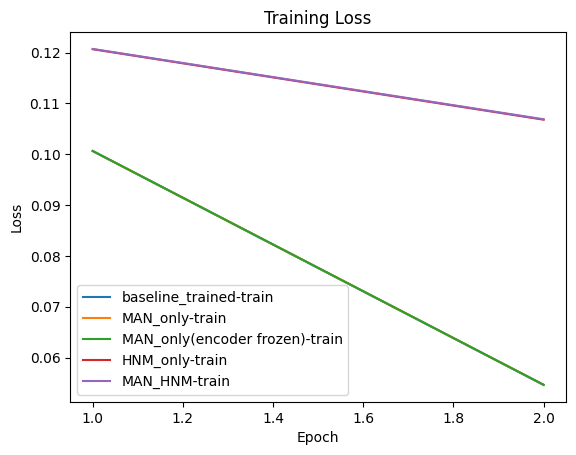

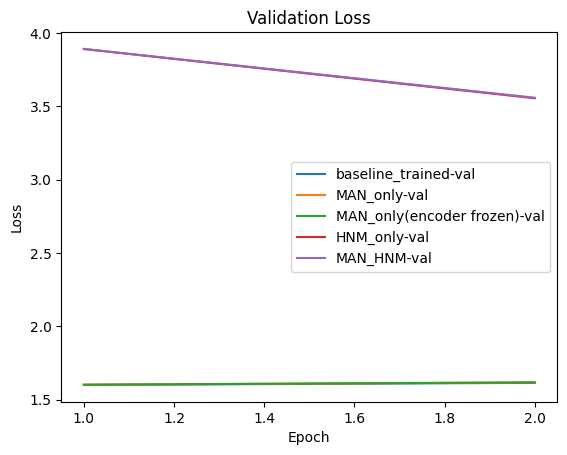

In [ ]:
plt.figure()
for name, res in results.items():
    if len(res["history"]["train_loss"]) == 0:
        continue
    plt.plot(range(1, len(res["history"]["train_loss"])+1), res["history"]["train_loss"], label=f"{name}-train")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss"); plt.legend(); plt.show()

plt.figure()
for name, res in results.items():
    if len(res["history"]["val_loss"]) == 0:
        continue
    plt.plot(range(1, len(res["history"]["val_loss"])+1), res["history"]["val_loss"], label=f"{name}-val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Validation Loss"); plt.legend(); plt.show()


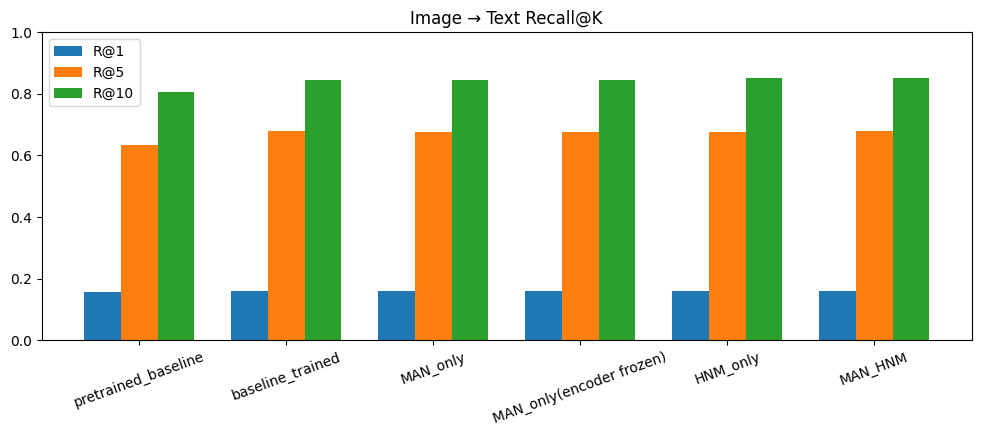

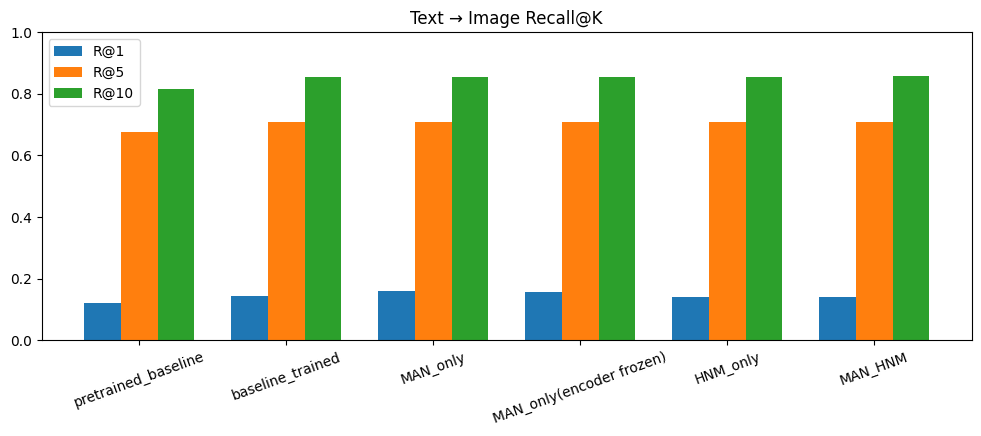

In [ ]:
labels = list(results.keys())
x = np.arange(len(labels))
w = 0.25

def m(name, key):
    return results[name]["metrics"][key]

plt.figure(figsize=(12,4))
plt.bar(x-w, [m(n,"i2t_R@1") for n in labels], width=w, label="R@1")
plt.bar(x,   [m(n,"i2t_R@5") for n in labels], width=w, label="R@5")
plt.bar(x+w, [m(n,"i2t_R@10") for n in labels], width=w, label="R@10")
plt.xticks(x, labels, rotation=20)
plt.ylim(0,1)
plt.title("Image → Text Recall@K")
plt.legend(); plt.show()

plt.figure(figsize=(12,4))
plt.bar(x-w, [m(n,"t2i_R@1") for n in labels], width=w, label="R@1")
plt.bar(x,   [m(n,"t2i_R@5") for n in labels], width=w, label="R@5")
plt.bar(x+w, [m(n,"t2i_R@10") for n in labels], width=w, label="R@10")
plt.xticks(x, labels, rotation=20)
plt.ylim(0,1)
plt.title("Text → Image Recall@K")
plt.legend(); plt.show()


In [ ]:
base = results["pretrained_baseline"]["metrics"]
keys = [
    "i2t_R@1","i2t_R@5","i2t_R@10",
    "t2i_R@1","t2i_R@5","t2i_R@10",
    "i2t_mean_rank","i2t_median_rank",
    "t2i_mean_rank","t2i_median_rank"
]

def fmt(x): return f"{x:.4f}" if isinstance(x, float) else str(x)

print("Pretrained baseline:")
for k in keys:
    print(f"  {k}: {fmt(base[k])}")

print("\nΔ vs pretrained baseline:")
for name, res in results.items():
    if name == "pretrained_baseline":
        continue
    print("\n", name)
    mtr = res["metrics"]
    for k in keys:
        d = mtr[k] - base[k]
        print(f"  {k}: {fmt(mtr[k])}  (Δ {d:+.4f})")


Pretrained baseline:
  i2t_R@1: 0.1570
  i2t_R@5: 0.6350
  i2t_R@10: 0.8060
  t2i_R@1: 0.1220
  t2i_R@5: 0.6760
  t2i_R@10: 0.8140
  i2t_mean_rank: 8.0250
  i2t_median_rank: 4.0000
  t2i_mean_rank: 9.0230
  t2i_median_rank: 4.0000

Δ vs pretrained baseline:

 baseline_trained
  i2t_R@1: 0.1600  (Δ +0.0030)
  i2t_R@5: 0.6790  (Δ +0.0440)
  i2t_R@10: 0.8450  (Δ +0.0390)
  t2i_R@1: 0.1420  (Δ +0.0200)
  t2i_R@5: 0.7070  (Δ +0.0310)
  t2i_R@10: 0.8560  (Δ +0.0420)
  i2t_mean_rank: 6.6800  (Δ -1.3450)
  i2t_median_rank: 4.0000  (Δ +0.0000)
  t2i_mean_rank: 8.0440  (Δ -0.9790)
  t2i_median_rank: 4.0000  (Δ +0.0000)

 MAN_only
  i2t_R@1: 0.1600  (Δ +0.0030)
  i2t_R@5: 0.6760  (Δ +0.0410)
  i2t_R@10: 0.8440  (Δ +0.0380)
  t2i_R@1: 0.1610  (Δ +0.0390)
  t2i_R@5: 0.7090  (Δ +0.0330)
  t2i_R@10: 0.8540  (Δ +0.0400)
  i2t_mean_rank: 6.6840  (Δ -1.3410)
  i2t_median_rank: 4.0000  (Δ +0.0000)
  t2i_mean_rank: 7.9470  (Δ -1.0760)
  t2i_median_rank: 4.0000  (Δ +0.0000)

 MAN_only(encoder frozen)
  i2t

Visualization & Comparison Block

📁 Saving plots to: /content/siglip_plots_20260120_101643
✅ Loaded: /content/ablation_results/results.json
Experiments: ['pretrained_baseline', 'baseline_trained', 'MAN_only', 'MAN_only(encoder frozen)', 'HNM_only', 'MAN_HNM']


,exp,i2t_R@1,t2i_R@1,i2t_R@5,t2i_R@5,i2t_R@10,t2i_R@10,i2t_mean_rank,i2t_median_rank,t2i_mean_rank,...,use_man,use_hnm,epochs,lr,weight_decay,unfreeze_last_vision,unfreeze_last_text,hnm_k,hnm_warmup_epochs,man_l2_train
0,pretrained_baseline,0.157,0.122,0.635,0.676,0.806,0.814,8.025,4.0,9.023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,baseline_trained,0.160,0.142,0.679,0.707,0.845,0.856,6.680,4.0,8.044,...,False,False,2.0,0.000003,0.01,2.0,2.0,10.0,2.0,True
2,MAN_only,0.160,0.161,0.676,0.709,0.844,0.854,6.684,4.0,7.947,...,True,False,2.0,0.000003,0.01,2.0,2.0,10.0,2.0,True
3,HNM_only,0.160,0.140,0.677,0.709,0.852,0.856,6.654,4.0,7.999,...,False,True,2.0,0.000003,0.01,2.0,2.0,10.0,2.0,True
4,MAN_HNM,0.160,0.141,0.679,0.708,0.850,0.857,6.649,4.0,8.049,...,True,True,2.0,0.000003,0.01,2.0,2.0,10.0,2.0,True
5,MAN_only(encoder frozen),0.160,0.157,0.676,0.709,0.844,0.853,6.683,4.0,7.965,...,True,False,2.0,0.000003,0.01,2.0,2.0,10.0,2.0,True


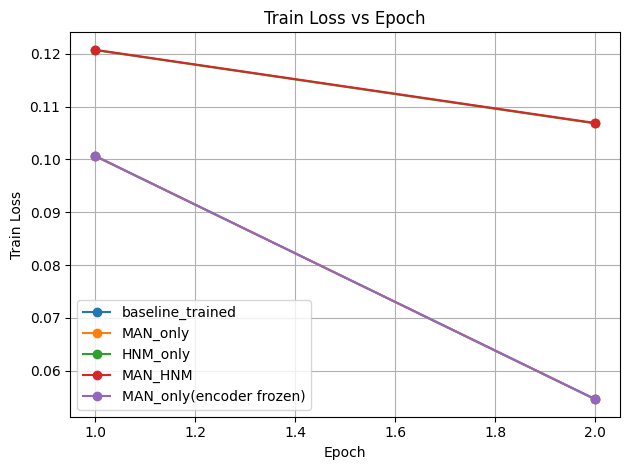

✅ Saved: /content/siglip_plots_20260120_101643/01_loss_train_vs_epoch.png


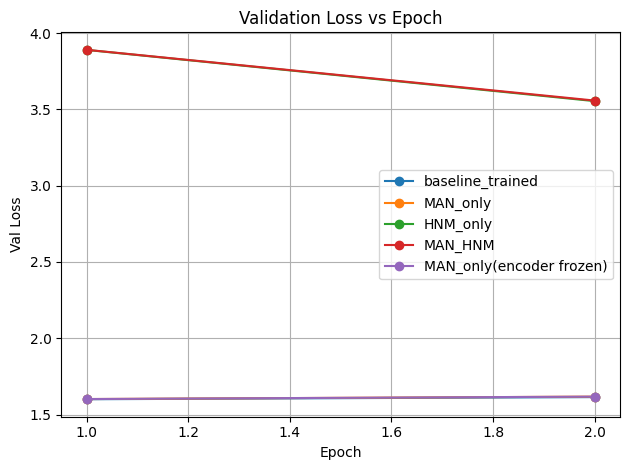

✅ Saved: /content/siglip_plots_20260120_101643/02_loss_val_vs_epoch.png


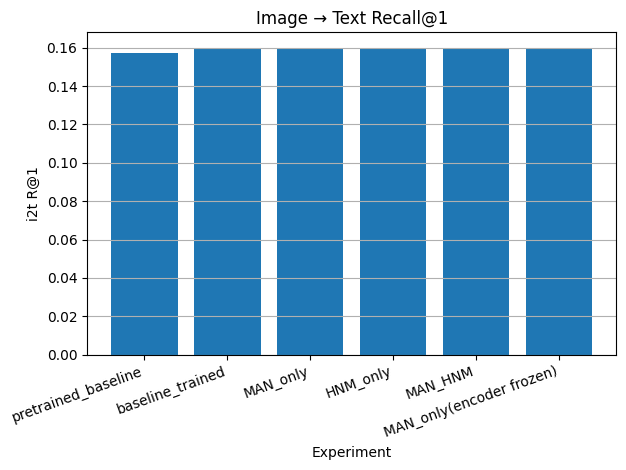

✅ Saved: /content/siglip_plots_20260120_101643/03_bars_i2t_R_1.png


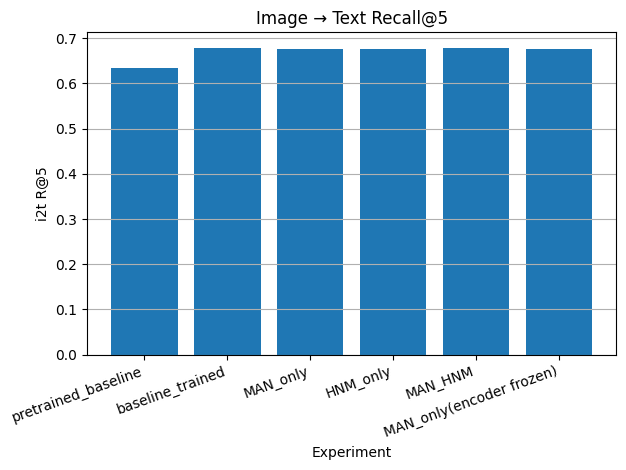

✅ Saved: /content/siglip_plots_20260120_101643/04_bars_i2t_R_5.png


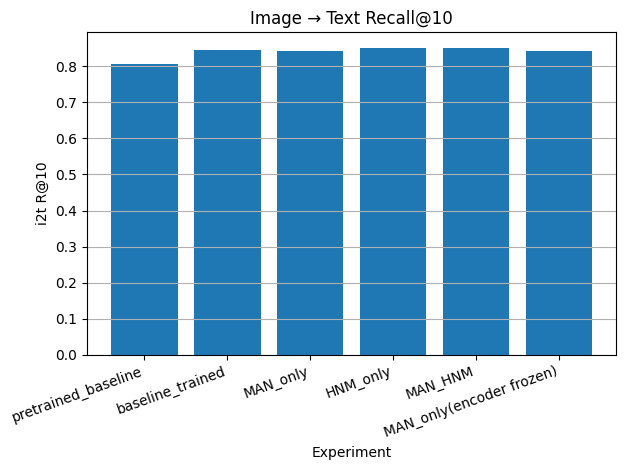

✅ Saved: /content/siglip_plots_20260120_101643/05_bars_i2t_R_10.png


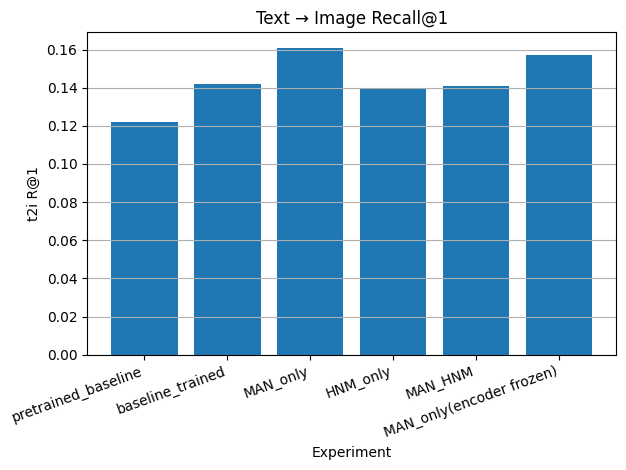

✅ Saved: /content/siglip_plots_20260120_101643/06_bars_t2i_R_1.png


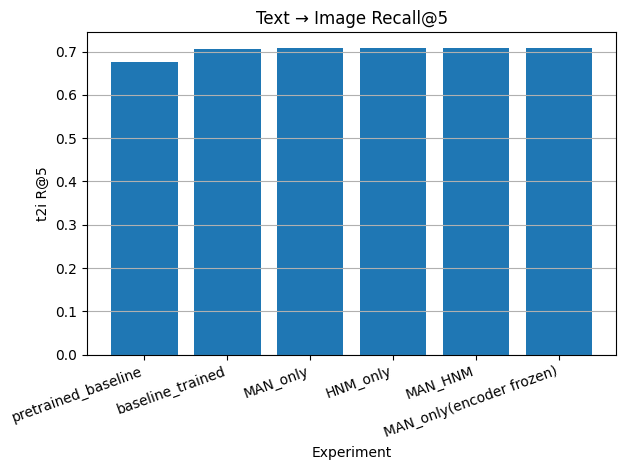

✅ Saved: /content/siglip_plots_20260120_101643/07_bars_t2i_R_5.png


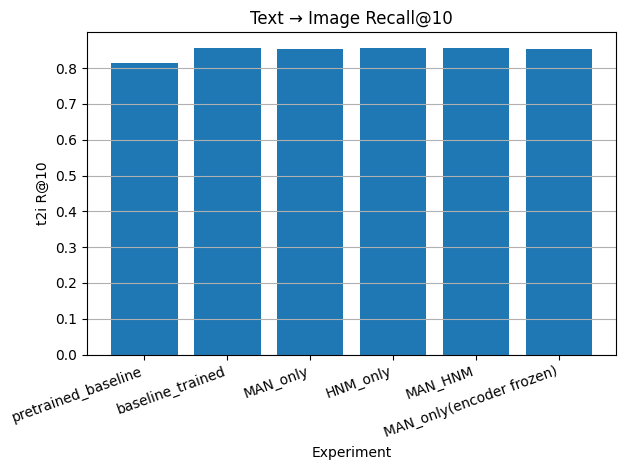

✅ Saved: /content/siglip_plots_20260120_101643/08_bars_t2i_R_10.png


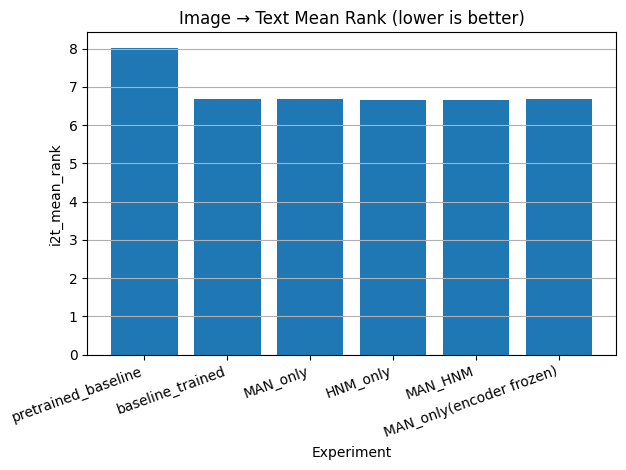

✅ Saved: /content/siglip_plots_20260120_101643/09_bars_i2t_mean_rank.png


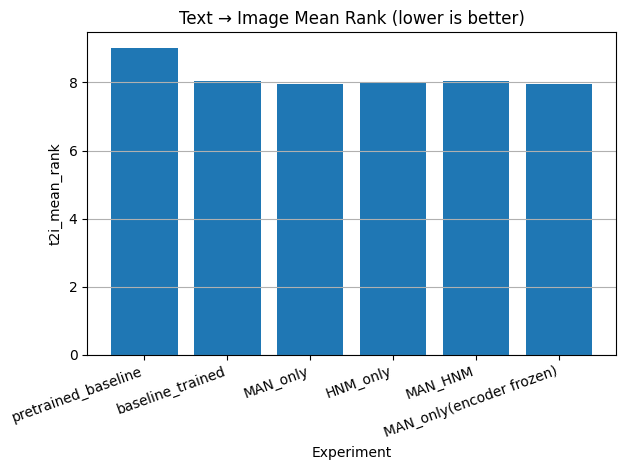

✅ Saved: /content/siglip_plots_20260120_101643/10_bars_t2i_mean_rank.png


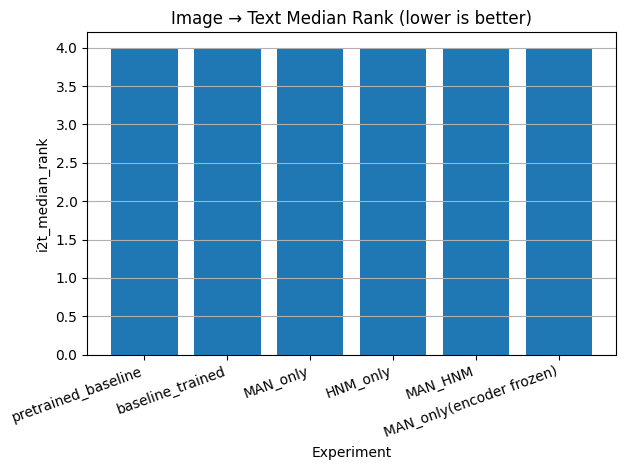

✅ Saved: /content/siglip_plots_20260120_101643/11_bars_i2t_median_rank.png


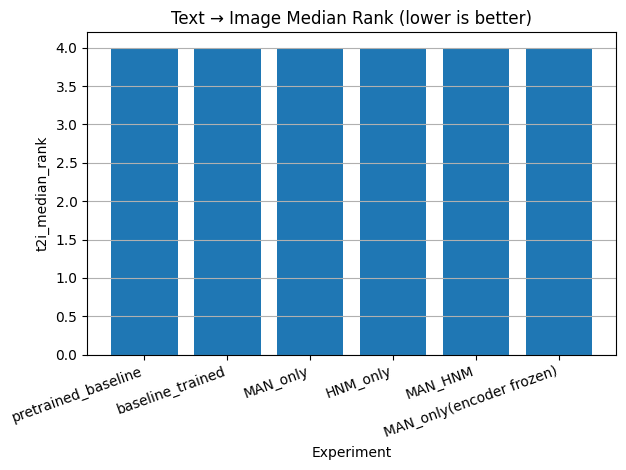

✅ Saved: /content/siglip_plots_20260120_101643/12_bars_t2i_median_rank.png
Δ plots baseline: baseline_trained


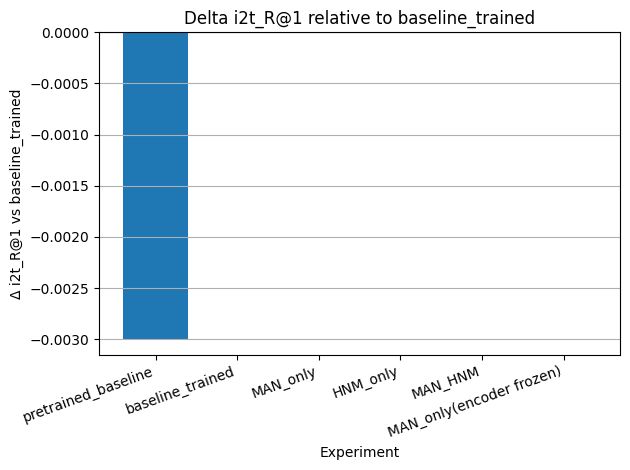

✅ Saved: /content/siglip_plots_20260120_101643/13_delta_i2t_R_1_vs_baseline_trained.png


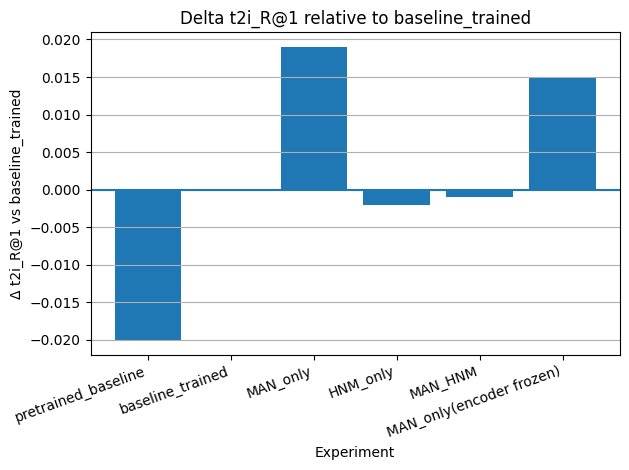

✅ Saved: /content/siglip_plots_20260120_101643/14_delta_t2i_R_1_vs_baseline_trained.png


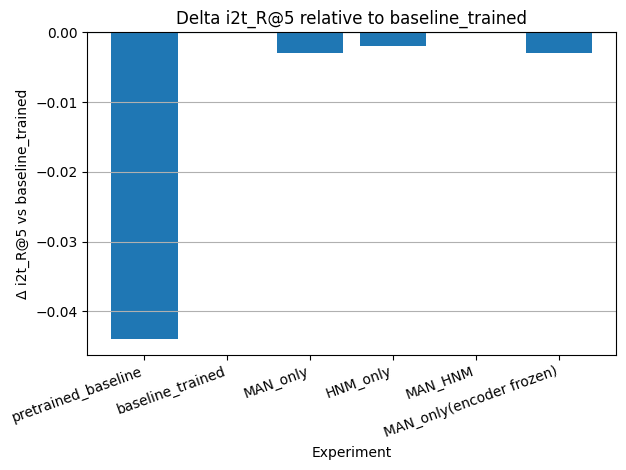

✅ Saved: /content/siglip_plots_20260120_101643/15_delta_i2t_R_5_vs_baseline_trained.png


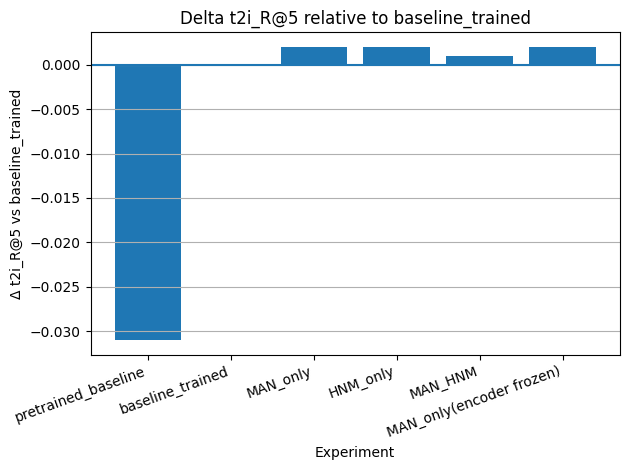

✅ Saved: /content/siglip_plots_20260120_101643/16_delta_t2i_R_5_vs_baseline_trained.png


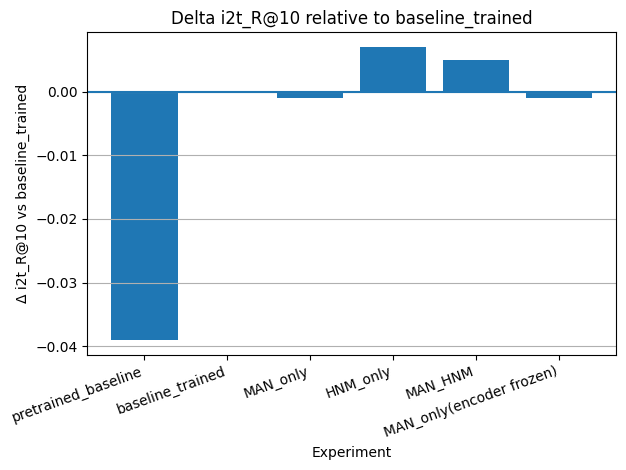

✅ Saved: /content/siglip_plots_20260120_101643/17_delta_i2t_R_10_vs_baseline_trained.png


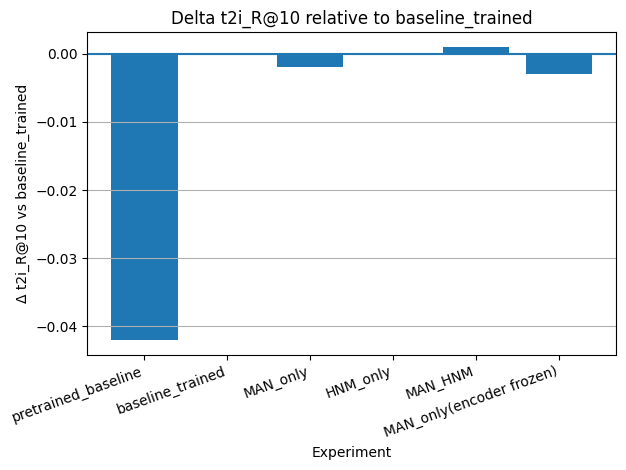

✅ Saved: /content/siglip_plots_20260120_101643/18_delta_t2i_R_10_vs_baseline_trained.png


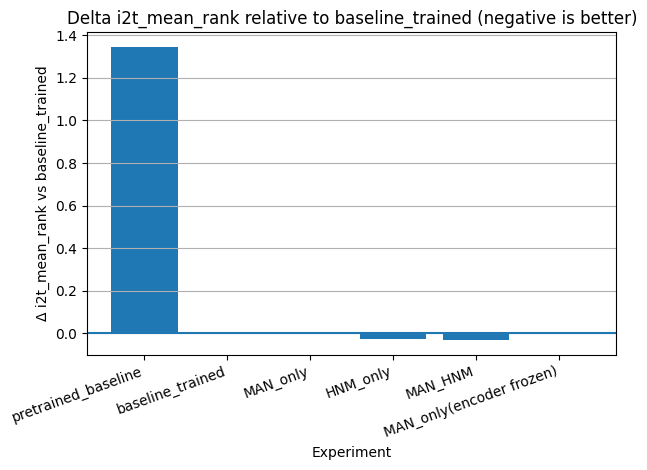

✅ Saved: /content/siglip_plots_20260120_101643/19_delta_i2t_mean_rank_vs_baseline_trained_negative_is_better.png


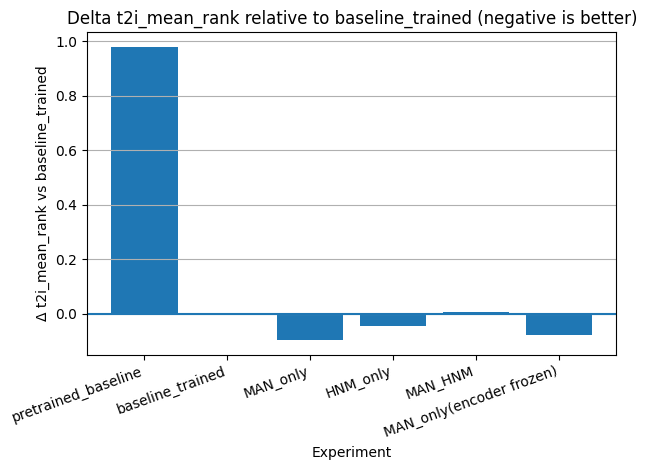

✅ Saved: /content/siglip_plots_20260120_101643/20_delta_t2i_mean_rank_vs_baseline_trained_negative_is_better.png


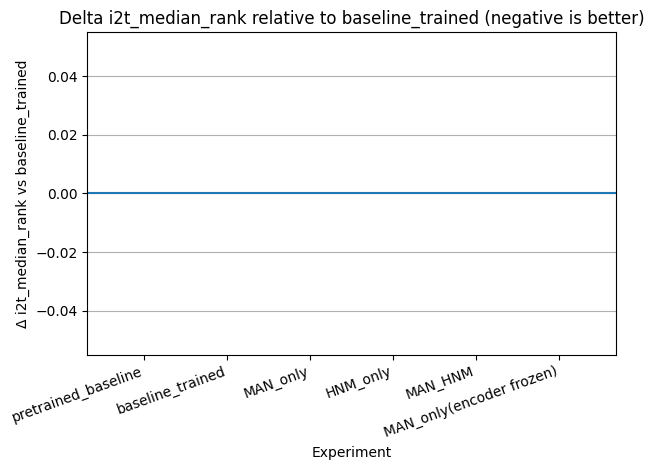

✅ Saved: /content/siglip_plots_20260120_101643/21_delta_i2t_median_rank_vs_baseline_trained_negative_is_better.png


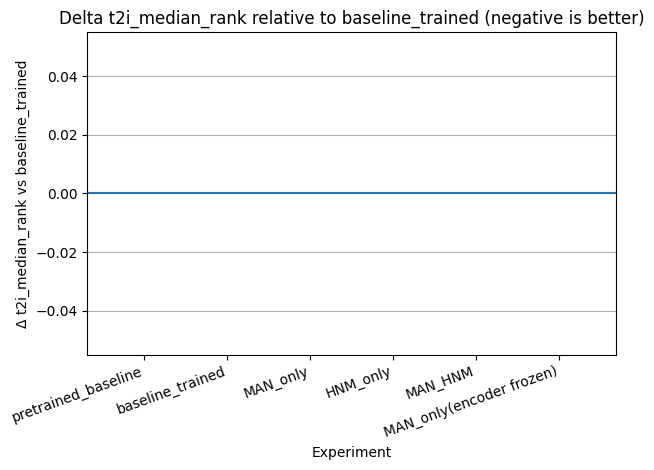

✅ Saved: /content/siglip_plots_20260120_101643/22_delta_t2i_median_rank_vs_baseline_trained_negative_is_better.png


,exp,i2t_R@1,i2t_R@5,i2t_R@10,t2i_R@1,t2i_R@5,t2i_R@10
0,pretrained_baseline,0.157,0.635,0.806,0.122,0.676,0.814
1,baseline_trained,0.160,0.679,0.845,0.142,0.707,0.856
2,MAN_only,0.160,0.676,0.844,0.161,0.709,0.854
3,HNM_only,0.160,0.677,0.852,0.140,0.709,0.856
4,MAN_HNM,0.160,0.679,0.850,0.141,0.708,0.857
5,MAN_only(encoder frozen),0.160,0.676,0.844,0.157,0.709,0.853


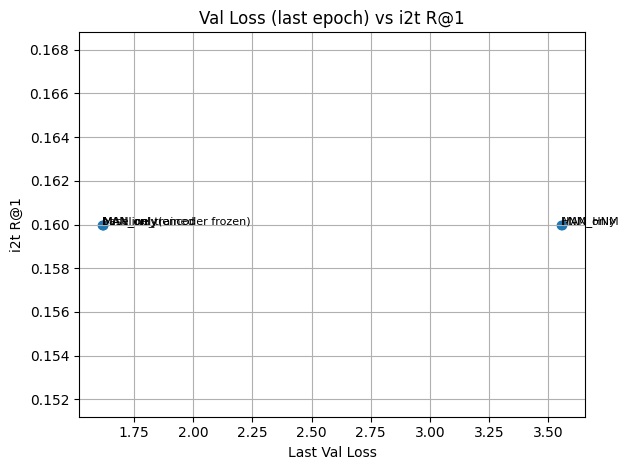

✅ Saved: /content/siglip_plots_20260120_101643/23_scatter_last_val_loss_vs_i2t_R_1.png


ValueError: mount failed

In [ ]:
# =========================
# ALL PLOTS + AUTO-SAVE (Drive + Download ZIP)
# Compatible with this notebook's results.json structure
# Generates (each as separate plot):
# 1) Train loss curves
# 2) Val loss curves
# 3) Bar charts: i2t R@{1,5,10}
# 4) Bar charts: t2i R@{1,5,10}
# 5) Bar charts: mean/median rank (i2t + t2i)
# 6) Delta vs baseline (baseline_trained if exists else pretrained_baseline)
# 7) Extra: recalls table + scatter (last val loss vs i2t R@1)
# Saves all plots to /content/siglip_plots_<timestamp>/, copies to Drive, downloads ZIP.
# =========================

import os, json, time, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# A) Plot saving utilities
# --------------------------
timestamp = time.strftime("%Y%m%d_%H%M%S")
PLOTS_DIR = os.path.join("/content", f"siglip_plots_{timestamp}")
os.makedirs(PLOTS_DIR, exist_ok=True)

_plot_counter = 0
def save_show(filename_prefix: str):
    global _plot_counter
    _plot_counter += 1
    safe = "".join(ch if ch.isalnum() or ch in "-_." else "_" for ch in filename_prefix)
    path = os.path.join(PLOTS_DIR, f"{_plot_counter:02d}_{safe}.png")
    plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()
    print("✅ Saved:", path)

print("📁 Saving plots to:", PLOTS_DIR)

def copy_plots_to_drive(drive_subdir="siglip_ablation_outputs"):
    from google.colab import drive
    drive.mount("/content/drive")
    drive_dir = f"/content/drive/MyDrive/{drive_subdir}/{timestamp}"
    os.makedirs(drive_dir, exist_ok=True)
    dst = os.path.join(drive_dir, os.path.basename(PLOTS_DIR))
    shutil.copytree(PLOTS_DIR, dst, dirs_exist_ok=True)
    print("✅ Copied plots folder to Drive:", dst)
    return dst

def zip_and_download_plots():
    from google.colab import files
    zip_path = shutil.make_archive(PLOTS_DIR, "zip", PLOTS_DIR)
    print("✅ Created zip:", zip_path)
    files.download(zip_path)

# --------------------------
# B) Locate results.json
# --------------------------
candidates = []
if "RESULTS_DIR" in globals():
    candidates.append(os.path.join(RESULTS_DIR, "results.json"))
if "RUNS_DIR" in globals():
    candidates.append(os.path.join(RUNS_DIR, "results.json"))  # fallback
candidates += [
    "/content/ablation_results/results.json",
    "/content/ablation_runs/results.json",
]

results_path = next((p for p in candidates if os.path.exists(p)), None)
if results_path is None:
    raise FileNotFoundError("Could not find results.json. Looked in:\n" + "\n".join(candidates))

with open(results_path, "r", encoding="utf-8") as f:
    results = json.load(f)

print("✅ Loaded:", results_path)
print("Experiments:", list(results.keys()))

# --------------------------
# C) Flatten results -> DataFrame
# --------------------------
rows = []
for exp_name, res in results.items():
    cfg = res.get("config", {}) or {}
    metrics = res.get("metrics", {}) or {}
    hist = res.get("history", {}) or {}

    row = {"exp": exp_name}

    for k in [
        "use_man","use_hnm","epochs","lr","weight_decay",
        "unfreeze_last_vision","unfreeze_last_text",
        "hnm_k","hnm_warmup_epochs","man_l2_train"
    ]:
        if k in cfg:
            row[k] = cfg[k]

    for mk, mv in metrics.items():
        row[mk] = mv

    row["train_loss_list"] = hist.get("train_loss", []) or []
    row["val_loss_list"]   = hist.get("val_loss", []) or []
    rows.append(row)

df = pd.DataFrame(rows)

preferred_order = ["pretrained_baseline", "baseline_trained", "MAN_only", "HNM_only", "MAN_HNM"]
df["order"] = df["exp"].apply(lambda x: preferred_order.index(x) if x in preferred_order else 999)
df = df.sort_values(["order", "exp"]).reset_index(drop=True).drop(columns=["order"])

display(df)

exp_names = df["exp"].tolist()

def _as_list(x):
    return x if isinstance(x, list) else []

def _to_float_series(col):
    return pd.to_numeric(df[col], errors="coerce") if col in df.columns else None

# --------------------------
# D) Loss curves
# --------------------------
plt.figure()
for _, r in df.iterrows():
    tr = _as_list(r["train_loss_list"])
    if len(tr) == 0:
        continue
    plt.plot(range(1, len(tr) + 1), tr, marker="o", label=r["exp"])
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss vs Epoch")
plt.legend()
plt.grid(True)
save_show("loss_train_vs_epoch")

plt.figure()
for _, r in df.iterrows():
    vl = _as_list(r["val_loss_list"])
    if len(vl) == 0:
        continue
    plt.plot(range(1, len(vl) + 1), vl, marker="o", label=r["exp"])
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.title("Validation Loss vs Epoch")
plt.legend()
plt.grid(True)
save_show("loss_val_vs_epoch")

# --------------------------
# E) Recall@K bar charts
# --------------------------
def bar_metric(col, title, ylabel, fname):
    if col not in df.columns:
        print(f"Missing column: {col} (skipping)")
        return
    vals = pd.to_numeric(df[col], errors="coerce")
    plt.figure()
    plt.bar(exp_names, vals)
    plt.xlabel("Experiment")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=20, ha="right")
    plt.grid(True, axis="y")
    save_show(fname)

for k in [1, 5, 10]:
    bar_metric(f"i2t_R@{k}", f"Image → Text Recall@{k}", f"i2t R@{k}", f"bars_i2t_R@{k}")
for k in [1, 5, 10]:
    bar_metric(f"t2i_R@{k}", f"Text → Image Recall@{k}", f"t2i R@{k}", f"bars_t2i_R@{k}")

# --------------------------
# F) Rank bars (lower is better)
# --------------------------
rank_cols = [
    ("i2t_mean_rank",   "Image → Text Mean Rank (lower is better)"),
    ("t2i_mean_rank",   "Text → Image Mean Rank (lower is better)"),
    ("i2t_median_rank", "Image → Text Median Rank (lower is better)"),
    ("t2i_median_rank", "Text → Image Median Rank (lower is better)"),
]
for col, title in rank_cols:
    if col not in df.columns:
        continue
    vals = pd.to_numeric(df[col], errors="coerce")
    plt.figure()
    plt.bar(exp_names, vals)
    plt.xlabel("Experiment")
    plt.ylabel(col)
    plt.title(title)
    plt.xticks(rotation=20, ha="right")
    plt.grid(True, axis="y")
    save_show(f"bars_{col}")

# --------------------------
# G) Delta vs baseline (fallback)
# --------------------------
baseline_name = "baseline_trained" if "baseline_trained" in exp_names else ("pretrained_baseline" if "pretrained_baseline" in exp_names else None)
if baseline_name is None:
    print("No baseline found for delta plots.")
else:
    base_row = df[df["exp"] == baseline_name].iloc[0]
    print("Δ plots baseline:", baseline_name)

    for col in ["i2t_R@1","t2i_R@1","i2t_R@5","t2i_R@5","i2t_R@10","t2i_R@10"]:
        if col not in df.columns:
            continue
        base_val = float(pd.to_numeric(base_row[col], errors="coerce"))
        vals = pd.to_numeric(df[col], errors="coerce")
        deltas = vals - base_val

        plt.figure()
        plt.bar(exp_names, deltas)
        plt.axhline(0.0)
        plt.xlabel("Experiment")
        plt.ylabel(f"Δ {col} vs {baseline_name}")
        plt.title(f"Delta {col} relative to {baseline_name}")
        plt.xticks(rotation=20, ha="right")
        plt.grid(True, axis="y")
        save_show(f"delta_{col}_vs_{baseline_name}")

    for col in ["i2t_mean_rank","t2i_mean_rank","i2t_median_rank","t2i_median_rank"]:
        if col not in df.columns:
            continue
        base_val = float(pd.to_numeric(base_row[col], errors="coerce"))
        vals = pd.to_numeric(df[col], errors="coerce")
        deltas = vals - base_val  # negative = improvement (lower is better)

        plt.figure()
        plt.bar(exp_names, deltas)
        plt.axhline(0.0)
        plt.xlabel("Experiment")
        plt.ylabel(f"Δ {col} vs {baseline_name}")
        plt.title(f"Delta {col} relative to {baseline_name} (negative is better)")
        plt.xticks(rotation=20, ha="right")
        plt.grid(True, axis="y")
        save_show(f"delta_{col}_vs_{baseline_name}_negative_is_better")

# --------------------------
# H) Extra: recalls table
# --------------------------
rec_cols = [c for c in ["i2t_R@1","i2t_R@5","i2t_R@10","t2i_R@1","t2i_R@5","t2i_R@10"] if c in df.columns]
if rec_cols:
    rec_df = df[["exp"] + rec_cols].copy()
    display(rec_df)

# --------------------------
# I) Extra: Scatter last val loss vs i2t R@1
# --------------------------
if "i2t_R@1" in df.columns:
    last_val_loss = df["val_loss_list"].apply(lambda x: _as_list(x)[-1] if len(_as_list(x)) > 0 else np.nan)
    r1 = pd.to_numeric(df["i2t_R@1"], errors="coerce")

    plt.figure()
    plt.scatter(last_val_loss, r1)
    for i, name in enumerate(exp_names):
        x = last_val_loss.iloc[i]
        y = r1.iloc[i]
        if not (np.isnan(x) or np.isnan(y)):
            plt.text(x, y, name, fontsize=8)
    plt.xlabel("Last Val Loss")
    plt.ylabel("i2t R@1")
    plt.title("Val Loss (last epoch) vs i2t R@1")
    plt.grid(True)
    save_show("scatter_last_val_loss_vs_i2t_R@1")

# --------------------------
# J) Save to Drive + Download ZIP
# --------------------------
drive_folder = copy_plots_to_drive("siglip_ablation_outputs")
zip_and_download_plots()

print(" Done.")
print("Local plots:", PLOTS_DIR)
print("Drive folder:", drive_folder)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _list_to_row(loss_list, max_len):
    loss_list = loss_list if isinstance(loss_list, list) else []
    out = [np.nan] * max_len
    for i in range(min(len(loss_list), max_len)):
        out[i] = float(loss_list[i])
    return out

# Find max epochs across experiments
max_ep = int(df["train_loss_list"].apply(lambda x: len(x) if isinstance(x, list) else 0).max())
max_ep = max(max_ep, int(df["val_loss_list"].apply(lambda x: len(x) if isinstance(x, list) else 0).max()))

if max_ep == 0:
    raise ValueError("No loss lists found in df (train_loss_list / val_loss_list are empty).")

epochs = [f"E{e}" for e in range(1, max_ep + 1)]

train_mat = np.vstack(df["train_loss_list"].apply(lambda x: _list_to_row(x, max_ep)).to_numpy())
val_mat   = np.vstack(df["val_loss_list"].apply(lambda x: _list_to_row(x, max_ep)).to_numpy())

# --- Train heatmap ---
plt.figure()
plt.imshow(train_mat, aspect="auto")
plt.colorbar(label="Train Loss")
plt.yticks(range(len(df)), df["exp"].tolist())
plt.xticks(range(max_ep), epochs)
plt.title("Train Loss Heatmap (Experiment × Epoch)")
plt.xlabel("Epoch")
plt.ylabel("Experiment")
plt.show()

# --- Val heatmap ---
plt.figure()
plt.imshow(val_mat, aspect="auto")
plt.colorbar(label="Val Loss")
plt.yticks(range(len(df)), df["exp"].tolist())
plt.xticks(range(max_ep), epochs)
plt.title("Validation Loss Heatmap (Experiment × Epoch)")
plt.xlabel("Epoch")
plt.ylabel("Experiment")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_loss_3d(df, col_list, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    for y, (_, r) in enumerate(df.iterrows()):
        losses = r[col_list] if isinstance(r[col_list], list) else []
        if len(losses) == 0:
            continue
        x = np.arange(1, len(losses) + 1)
        z = np.array(losses, dtype=float)
        yy = np.full_like(x, y)
        ax.plot(x, yy, z, marker="o", label=r["exp"])

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Experiment")
    ax.set_zlabel("Loss")
    ax.set_yticks(range(len(df)))
    ax.set_yticklabels(df["exp"].tolist())
    ax.set_title(title)
    plt.show()

plot_loss_3d(df, "train_loss_list", "3D Train Loss (Epoch × Experiment × Loss)")
plot_loss_3d(df, "val_loss_list", "3D Val Loss (Epoch × Experiment × Loss)")


OPTIONAL: Qualitative retrieval examples

In [ ]:
# ===== Qualitative retrieval: compare two experiments on a small val subset =====
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from transformers import SiglipModel, SiglipProcessor

# --- Config ---
QUAL_ENABLE = True
QUAL_EXP_A = "pretrained_baseline"
QUAL_EXP_B = "MAN_HNM"
QUAL_NUM_EXAMPLES = 7
QUAL_TOPK = 5
QUAL_MAX_VAL_SAMPLES = 200  # keep small for speed

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if QUAL_ENABLE:
    try:
        # Use the same processor as training
        _proc = SiglipProcessor.from_pretrained(MODEL_NAME)

        # ---- Helper: locate checkpoint dir ----
        def _get_exp_dir(exp_name: str) -> str:
            # In this notebook checkpoints were saved under RESULTS_DIR/<exp_name>
            p1 = os.path.join(RESULTS_DIR, exp_name)
            p2 = os.path.join(RUNS_DIR, exp_name) if "RUNS_DIR" in globals() else None
            if os.path.exists(p1):
                return p1
            if p2 is not None and os.path.exists(p2):
                return p2
            raise FileNotFoundError(
                f"Missing checkpoint dir for {exp_name}. Tried: {p1}" + (f", {p2}" if p2 else "")
            )

        # ---- Helper: load MAN head if exists (state_dict only; infer embed_dim) ----
        # Requires MANHead class to be defined in your notebook.
        def _load_man_if_exists(exp_dir: str):
            man_path = os.path.join(exp_dir, "man_head.pt")
            if not os.path.exists(man_path):
                return None

            sd = torch.load(man_path, map_location="cpu")  # plain state_dict

            # Infer embed_dim from LayerNorm weights
            if "ln_img.weight" in sd:
                embed_dim = int(sd["ln_img.weight"].numel())
            elif "ln_txt.weight" in sd:
                embed_dim = int(sd["ln_txt.weight"].numel())
            else:
                raise KeyError(
                    f"Could not infer embed_dim from man_head state_dict keys. "
                    f"Example keys: {list(sd.keys())[:12]}"
                )

            man = MANHead(embed_dim)  # matches your MANHead(embed_dim) definition
            man.load_state_dict(sd)
            man.eval()
            return man

        # ---- Helper: subset a PyTorch Dataset by indices ----
        class SubsetDataset(Dataset):
            def __init__(self, base_ds, indices):
                self.base_ds = base_ds
                self.indices = list(indices)

            def __len__(self):
                return len(self.indices)

            def __getitem__(self, i):
                return self.base_ds[self.indices[i]]

        def _subset_val_dataset_pytorch(dataset, n: int, seed: int = 0):
            n = min(n, len(dataset))
            rng = np.random.default_rng(seed)
            idx = rng.choice(len(dataset), size=n, replace=False)
            return SubsetDataset(dataset, idx), idx

        # ---- Collate that also keeps raw captions for printing ----
        def collate_with_texts(batch):
            images, texts = zip(*batch)  # LocalImageTextDataset returns (PIL.Image, text)
            batch_t = _proc(
                images=list(images),
                text=list(texts),
                padding="max_length",
                truncation=True,
                max_length=MAX_LEN,
                return_tensors="pt",
            )
            batch_t["raw_texts"] = list(texts)
            return batch_t

        def _load_exp_model(exp_name: str):
            exp_dir = _get_exp_dir(exp_name)
            model = SiglipModel.from_pretrained(exp_dir).to(DEVICE)
            model.eval()

            man = _load_man_if_exists(exp_dir)
            if man is not None:
                man = man.to(DEVICE)
                man.eval()

            return model, man, exp_dir

        @torch.no_grad()
        def _compute_embeds_for_dataset(model, man, dataset):
            dl = DataLoader(
                dataset,
                batch_size=BATCH_SIZE,
                shuffle=False,
                num_workers=0,
                collate_fn=collate_with_texts,
            )

            all_i, all_t, all_caps = [], [], []
            for batch in dl:
                all_caps.extend(batch["raw_texts"])

                batch_t = {k: v.to(DEVICE) for k, v in batch.items() if isinstance(v, torch.Tensor)}
                out = model(**batch_t)

                zi = out.image_embeds
                zt = out.text_embeds

                if man is not None:
                    zi, zt = man(zi, zt, l2_normalize=True)
                else:
                    zi = F.normalize(zi, dim=-1)
                    zt = F.normalize(zt, dim=-1)

                all_i.append(zi.float().cpu())
                all_t.append(zt.float().cpu())

            img_emb = torch.cat(all_i, dim=0)
            txt_emb = torch.cat(all_t, dim=0)
            return img_emb, txt_emb, all_caps

        def _topk_texts_for_image(sim_row: torch.Tensor, captions, k: int):
            vals, idx = torch.topk(sim_row, k=min(k, sim_row.numel()))
            out = []
            for v, i in zip(vals, idx):
                ii = int(i)
                out.append((ii, float(v), captions[ii]))
            return out

        # ---- Build small val subset (PyTorch-safe) ----
        val_small, _ = _subset_val_dataset_pytorch(val_ds, QUAL_MAX_VAL_SAMPLES, seed=SEED)

        # ---- Load two experiments ----
        print(f"\n[QUAL] Loading models: {QUAL_EXP_A} vs {QUAL_EXP_B}")
        model_a, man_a, dir_a = _load_exp_model(QUAL_EXP_A)
        model_b, man_b, dir_b = _load_exp_model(QUAL_EXP_B)
        print("[QUAL] A dir:", dir_a)
        print("[QUAL] B dir:", dir_b)

        # ---- Compute embeddings on the same val subset ----
        print("[QUAL] Computing embeddings on val subset...")
        img_a, txt_a, caps = _compute_embeds_for_dataset(model_a, man_a, val_small)
        img_b, txt_b, _    = _compute_embeds_for_dataset(model_b, man_b, val_small)

        sim_a = img_a @ txt_a.T
        sim_b = img_b @ txt_b.T

        # ---- Pick random examples from subset ----
        rng = np.random.default_rng(SEED)
        ex_ids = rng.choice(sim_a.shape[0], size=min(QUAL_NUM_EXAMPLES, sim_a.shape[0]), replace=False)

        for ex in ex_ids:
            pil_img, gt_caption = val_small[int(ex)]

            top_a = _topk_texts_for_image(sim_a[int(ex)], caps, QUAL_TOPK)
            top_b = _topk_texts_for_image(sim_b[int(ex)], caps, QUAL_TOPK)

            plt.figure()
            plt.imshow(pil_img)
            plt.axis("off")
            plt.title(f"Subset idx={int(ex)} | GT: {gt_caption[:120]}")
            plt.show()

            print(f"\n--- {QUAL_EXP_A} Top-{QUAL_TOPK} ---")
            for rank, (idx, score, cap) in enumerate(top_a, start=1):
                marker = "✅" if idx == int(ex) else "  "
                print(f"{marker} {rank:>2}. (idx={idx}) score={score:.4f} | {cap}")

            print(f"\n--- {QUAL_EXP_B} Top-{QUAL_TOPK} ---")
            for rank, (idx, score, cap) in enumerate(top_b, start=1):
                marker = "✅" if idx == int(ex) else "  "
                print(f"{marker} {rank:>2}. (idx={idx}) score={score:.4f} | {cap}")

        print("\n[QUAL] Done.")

    except Exception as e:
        print("\n[QUAL] Skipped qualitative section due to error:")
        print(type(e).__name__, ":", str(e))
        print("Tip: ensure experiments exist under RESULTS_DIR/<exp_name>/ and that MANHead is defined.")


In [ ]:
# ===== Find and display a "baseline fails, MAN_HNM succeeds" example =====
FAIL_TOPK = QUAL_TOPK

def _topk_indices(sim_row: torch.Tensor, k: int):
    _, idx = torch.topk(sim_row, k=min(k, sim_row.numel()))
    return set(int(i) for i in idx)

# Scan all subset examples
candidates = []
for i in range(sim_a.shape[0]):
    top_a = _topk_indices(sim_a[i], FAIL_TOPK)
    top_b = _topk_indices(sim_b[i], FAIL_TOPK)

    a_hits = (i in top_a)
    b_hits = (i in top_b)

    if (not a_hits) and b_hits:
        # optional: store "how bad baseline is" vs "how good B is"
        # rank proxy: use similarity gap between GT and best
        gt_a = float(sim_a[i, i])
        gt_b = float(sim_b[i, i])
        candidates.append((i, gt_a, gt_b))

print(f"Found {len(candidates)} candidates where baseline misses Top-{FAIL_TOPK} but MAN_HNM hits.")

if len(candidates) == 0:
    print("No such examples in this subset. Try increasing QUAL_MAX_VAL_SAMPLES (e.g., 800) or using K=1/3.")
else:
    # pick the strongest improvement: highest (gt_b - gt_a)
    candidates.sort(key=lambda x: (x[2] - x[1]), reverse=True)
    ex, gt_a, gt_b = candidates[0]
    print(f"Showing example idx={ex} | baseline GT sim={gt_a:.4f} | MAN_HNM GT sim={gt_b:.4f}")

    # display the image + GT caption
    pil_img, gt_caption = val_small[int(ex)]
    plt.figure()
    plt.imshow(pil_img)
    plt.axis("off")
    plt.title(f"Baseline fails / MAN_HNM succeeds | idx={ex}\nGT: {gt_caption[:120]}")
    plt.show()

    # print Top-K lists for both
    top_a_list = _topk_texts_for_image(sim_a[int(ex)], caps, FAIL_TOPK)
    top_b_list = _topk_texts_for_image(sim_b[int(ex)], caps, FAIL_TOPK)

    print(f"\n--- {QUAL_EXP_A} Top-{FAIL_TOPK} ---")
    for rank, (idx, score, cap) in enumerate(top_a_list, start=1):
        marker = "✅" if idx == int(ex) else "  "
        print(f"{marker} {rank:>2}. (idx={idx}) score={score:.4f} | {cap}")

    print(f"\n--- {QUAL_EXP_B} Top-{FAIL_TOPK} ---")
    for rank, (idx, score, cap) in enumerate(top_b_list, start=1):
        marker = "✅" if idx == int(ex) else "  "
        print(f"{marker} {rank:>2}. (idx={idx}) score={score:.4f} | {cap}")


In [ ]:
# ===== Show multiple cases: baseline fails, MAN_HNM succeeds =====
FAIL_TOPK = QUAL_TOPK
NUM_CASES_TO_SHOW = 3  # <- כמה דוגמאות להציג

def _topk_indices(sim_row: torch.Tensor, k: int):
    _, idx = torch.topk(sim_row, k=min(k, sim_row.numel()))
    return set(int(i) for i in idx)

# Collect candidates
candidates = []
for i in range(sim_a.shape[0]):
    top_a = _topk_indices(sim_a[i], FAIL_TOPK)
    top_b = _topk_indices(sim_b[i], FAIL_TOPK)

    if (i not in top_a) and (i in top_b):
        gt_a = float(sim_a[i, i])
        gt_b = float(sim_b[i, i])
        candidates.append((i, gt_a, gt_b, gt_b - gt_a))

print(f"Found {len(candidates)} candidates where baseline misses Top-{FAIL_TOPK} but MAN_HNM hits.")

if len(candidates) == 0:
    print("No such examples in this subset. Try increasing QUAL_MAX_VAL_SAMPLES or using smaller K.")
else:
    # sort by biggest improvement
    candidates.sort(key=lambda x: x[3], reverse=True)

    num_show = min(NUM_CASES_TO_SHOW, len(candidates))
    print(f"Showing {num_show} strongest cases.\n")

    for j in range(num_show):
        ex, gt_a, gt_b, imp = candidates[j]

        print("=" * 90)
        print(f"Example #{j+1} | idx={ex} | baseline sim={gt_a:.4f} | MAN_HNM sim={gt_b:.4f} | Δ={imp:.4f}")

        pil_img, gt_caption = val_small[int(ex)]
        plt.figure()
        plt.imshow(pil_img)
        plt.axis("off")
        plt.title(f"Baseline fails / MAN_HNM succeeds\nGT: {gt_caption[:120]}")
        plt.show()

        top_a_list = _topk_texts_for_image(sim_a[int(ex)], caps, FAIL_TOPK)
        top_b_list = _topk_texts_for_image(sim_b[int(ex)], caps, FAIL_TOPK)

        print(f"\n--- {QUAL_EXP_A} Top-{FAIL_TOPK} ---")
        for rank, (idx, score, cap) in enumerate(top_a_list, start=1):
            marker = "✅" if idx == int(ex) else "  "
            print(f"{marker} {rank:>2}. (idx={idx}) score={score:.4f} | {cap}")

        print(f"\n--- {QUAL_EXP_B} Top-{FAIL_TOPK} ---")
        for rank, (idx, score, cap) in enumerate(top_b_list, start=1):
            marker = "✅" if idx == int(ex) else "  "
            print(f"{marker} {rank:>2}. (idx={idx}) score={score:.4f} | {cap}")


Save Results

In [ ]:
import os, shutil, time
from google.colab import drive

# 1) Mount Drive
drive.mount("/content/drive")

# 2)
timestamp = time.strftime("%Y%m%d_%H%M%S")
DRIVE_OUT_DIR = f"/content/drive/MyDrive/{timestamp}"
os.makedirs(DRIVE_OUT_DIR, exist_ok=True)

# 3)
RESULTS_PATH = os.path.join(RESULTS_DIR, "results.json")
if os.path.exists(RESULTS_PATH):
    shutil.copy2(RESULTS_PATH, os.path.join(DRIVE_OUT_DIR, "results.json"))
    print("Copied results.json to:", DRIVE_OUT_DIR)
else:
    print("results.json not found at:", RESULTS_PATH)

#
if os.path.exists(RUNS_DIR):
    shutil.copytree(RUNS_DIR, os.path.join(DRIVE_OUT_DIR, "ablation_runs"), dirs_exist_ok=True)
    print("Copied RUNS_DIR to:", os.path.join(DRIVE_OUT_DIR, "ablation_runs"))
else:
    print("RUNS_DIR not found:", RUNS_DIR)


In [ ]:
import os
from google.colab import files

RESULTS_PATH = os.path.join(RESULTS_DIR, "results.json")
if os.path.exists(RESULTS_PATH):
    files.download(RESULTS_PATH)
else:
    print("results.json not found:", RESULTS_PATH)
